In [1]:
# 日本語フォントをダウンロード
!apt -y install fonts-noto-cjk

!rm /root/.cache/matplotlib/fontlist-v310.json
# ランタイムを再起動する

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20190409+repack1-0ubuntu0.18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


## about resources

In [0]:
!cat /proc/uptime | awk '{print $1 /60 " mins (" $1 "sec)"}'

In [0]:
!cat /etc/issue

In [0]:
!uname -a

In [0]:
!df -h

In [0]:
!free -h

In [0]:
!cat /proc/cpuinfo

In [0]:
!nvidia-smi

# connecting to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/My Drive/millionlive_idol_prediction/

/content/drive/My Drive/millionlive_idol_prediction


In [0]:
!ls -l

# settings

In [0]:
!python --version

In [0]:
%config inlineBackend.figure_format = 'retina'

# training

In [7]:
import torch
import sys, os.path, glob
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import random
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

root_dir = './'
idol_script_file = root_dir + 'millionlive_idol_script.csv'
tmp_dir = root_dir + 'tmp/'

max_length = 90
batch_size = 100

class MillionLiveIdolScriptsDataset(Dataset):
    """
    dataset of the idolm@ster million live idol scripts

    Args:
            csv_file (string): path to the csv file which contains idol's scripts
    """
    
    def __init__(self, csv_file=idol_script_file, transform=None):
        self.idol_data_frame = pd.read_csv(csv_file)
        self.transform = transform

        print(self.idol_data_frame)

    def __len__(self):         
        return len(self.idol_data_frame)
        
    def __getitem__(self, idx):
        label = self.idol_data_frame.iat[idx, 0] # int
        _idol_id = self.idol_data_frame.iat[idx, 1]
        script_data = self.idol_data_frame.iat[idx, 2]

        if self.transform:
            label, _idol_id, script_data = self.transform(label, _idol_id, script_data)

        return label, _idol_id, script_data

class StringToTensor(object):
    """
    Convert the id in the sample to Tensors.
    """

    def __init__(self, max_length):
        self.max_length = max_length
    
    def __string_to_tensor(self, _str):
        _encoded_str = [ord(_x) for _x in str(_str).strip()]
        # return an encoded string as an array like below
        # [12450, 12452, 12489, 12523, 12395, 12394, 12387, 12390, 12289, 31169, 12398, 22818, 12395, 33394, 12364, 12388, 12365, 12414, 12375, 12383, 12290, 20449, 12376, 12390, 27497, 12365, 32154, 12369, 12390, 12356, 12428, 12400, 12289, 12365, 12387, 12392, 12289, 12356, 12388, 12363, 8230, 12290, 12503, 12525, 12487, 12517, 12540, 12469, 12540, 12290, 31169, 12289, 32118, 23550, 12395, 23626, 12369, 12390, 12415, 12379, 12414, 12377, 12397, 65281]
        _encoded_str = _encoded_str[:self.max_length]
        _str_len = len(str(_str)) # string length
        if _str_len < self.max_length: # if string length is less than a num of max_length, do zero padding
            _encoded_str += ([0] * (self.max_length - _str_len))
        
        return _encoded_str

    def __call__(self, _id, _idol_id, _script):
        
        _script = self.__string_to_tensor(_script)

        return _id, _idol_id, torch.tensor(_script, dtype=torch.long)
    
class CLCNN(nn.Module):
    def __init__(self, max_length, output_dim, embed_size=128, filter_sizes=(2, 3, 4, 5), filter_num=200, dropout=0.2):
        super(CLCNN, self).__init__() # call the method of this super class
        
        self.emb = nn.Embedding(65535, embed_size, padding_idx=0) #  65535 characters in vocab, embed_size dimensional embeddings
        self.dropout = nn.Dropout(dropout)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, filter_num, (k, embed_size)) for k in filter_sizes])
        self.bns1 = nn.ModuleList([nn.BatchNorm2d(filter_num, momentum=0.11) for _ in filter_sizes])
        self.fc1 = nn.Linear(filter_num * len(filter_sizes), output_dim)
   
    def forward(self, x):
        #print('input:', x.size())
        out = self.emb(x) # (N,W,D)
        #print('emb weight:\n', self.emb.weight)
        emb_out = out.unsqueeze(1) # insert a dimension (N,Ci,W,D)
        drop_out = self.dropout(emb_out)
        #print('emb_ex:', emb_out.size())
        relu_bn_out = [F.relu(bn(conv(drop_out))).squeeze(3) for conv, bn in zip(self.convs1, self.bns1)] #[(N,Co,W), ...]*len(Fs)
        maxpool_out = []
        for j in relu_bn_out:
            #[(N,Co), ...]*len(Fs)
            kn_size = tuple((j.size(2),))
            maxpool_out.append(F.max_pool1d(j, kernel_size=kn_size).squeeze(2))
        concated_out = torch.cat(maxpool_out, 1)
        #print('concatnated:', concated_out.size())
        out = self.fc1(concated_out) # (N,len(Ks)*Co)
        #print('output:', out.size())
        
        return out
        
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (labels, idol_ids, scripts)  in enumerate(train_loader):
        labels = labels.to(device)
        scripts = scripts.to(device)

        optimizer.zero_grad()
        outputs = model(scripts)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        predicted = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        total += labels.size(0) # dim 0 is batch size

        loss.backward()
        optimizer.step()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return train_loss, train_acc

def valid(model, optimizer, criterion, test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (labels, idol_ids, scripts)  in enumerate(test_loader):
            labels = labels.to(device)
            scripts = scripts.to(device)

            outputs = model(scripts)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            total += labels.size(0) # dim 0 is batch size
    
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total

    return val_loss, val_acc

device: cuda


In [8]:
transformed_script_dataset = MillionLiveIdolScriptsDataset(transform=StringToTensor(max_length))

# split dataset
n_samples = len(transformed_script_dataset)
train_size = int(len(transformed_script_dataset) * 0.9)
test_size = n_samples - train_size

train_data, test_data = torch.utils.data.random_split(transformed_script_dataset, [train_size, test_size])
# test dataset loader
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

"""
for i_batch, (id, idol_id, script)  in enumerate(train_loader):
    print('index:', i_batch)
    print('id:', id.size())
    print('idol_id:', idol_id)
    print('script:', script.size())
"""

# generate an idol dictionary
idol_df = transformed_script_dataset.idol_data_frame.set_index('id')
idol_dict = idol_df['idol_id'].drop_duplicates().to_dict()

      id idol_id                                             script
0      0  haruka                 トップアイドル目指して、歌も踊りも頑張ります！よろしくお願いします♪
1      0  haruka                               お仕事、頑張るぞー！なーんて、えへへ…。
2      0  haruka                                   張り切っていっちゃいましょうっ！
3      0  haruka                      あの、クッキー焼いてきたんですけど、食べてもらえますか…？
4      0  haruka                              プロデューサーさん、いつもお疲れさまです♪
...   ..     ...                                                ...
8350  49  sayoko  プロデューサーが聞いてくれるから、つい…色々と話し過ぎちゃいました。もしかして、そういう作戦...
8351  49  sayoko  朝から汗をかくのって、気持ちいいですよね。この調子で、あと10周いっちゃいましょう！プロデュ...
8352  49  sayoko  終わった後のことなんて、考えません！ただ、私の精一杯の歌とダンスを、ファンのみんなに見てもら...
8353  49  sayoko  見てください、プロデューサー。この衣装、動くと綺麗な音が鳴るんですよ！…ほら、なんて素敵な音...
8354  49  sayoko  アイドルになって、私の夢に色がつきました。信じて歩き続けていれば、きっと、いつか…。プロデュ...

[8355 rows x 3 columns]


In [10]:
!pip install adabound

In [0]:
SEED = 2020
def seed_torch(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [12]:
import adabound
import copy

learning_rate = 1e-3
seed_torch()
# build a model
model = CLCNN(max_length=max_length, output_dim=50).to(device)
print(model)
# set optimizer and loss function
optimizer = adabound.AdaBound(model.parameters(), lr=learning_rate, final_lr=0.1, weight_decay=5e-3)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
# for reproductibity
init_state = copy.deepcopy(model.state_dict())
init_state_opt = copy.deepcopy(optimizer.state_dict())

CLCNN(
  (emb): Embedding(65535, 128, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (convs1): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(2, 128), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(3, 128), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(4, 128), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(5, 128), stride=(1, 1))
  )
  (bns1): ModuleList(
    (0): BatchNorm2d(200, eps=1e-05, momentum=0.11, affine=True, track_running_stats=True)
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.11, affine=True, track_running_stats=True)
    (2): BatchNorm2d(200, eps=1e-05, momentum=0.11, affine=True, track_running_stats=True)
    (3): BatchNorm2d(200, eps=1e-05, momentum=0.11, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=800, out_features=50, bias=True)
)


In [0]:
import time
from sklearn.preprocessing import LabelEncoder

def fit_with_cv(model, optimizer, criterion, fold, dataset, num_epochs):
    train_data_arr = []
    train_loss_acc_history = []
    val_loss_acc_history = []
    
    # datasetをnumpy配列に変換
    for id, idol_id, script_data in dataset:
        train_data_arr.append((id, script_data.numpy()))
    train_data_mat = np.array(train_data_arr)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train_data_mat[:,0]) # 分割用にone-hotに変換

    X = np.zeros((1, max_length))
    for script_row in train_data_mat[:,1]:
        X = np.vstack([X, script_row])
    X = X[1:] # 最初の行を削除

    print(y.shape)
    print(X.shape)

    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(X, y)):
        print('fold: {}/{}'.format(fold_idx + 1, fold.n_splits))

        # どう分割されたか確認
        #print('train data:', y[train_idx], 'valid data:', y[valid_idx])

        model.load_state_dict(init_state)
        optimizer.load_state_dict(init_state_opt)

        # dataset loader
        train_loader = DataLoader(Subset(dataset, train_idx), shuffle=True, batch_size=batch_size)
        valid_loader = DataLoader(Subset(dataset, valid_idx), shuffle=False, batch_size=batch_size)

        for epoch_idx in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train(model, optimizer, criterion, train_loader)
            val_loss, val_acc = valid(model, optimizer, criterion, valid_loader)

            elapsed_time = time.time() - start_time 
            print('epoch: %d/%d | train loss: %.4f | train acc %.4f | val loss: %.4f | val acc: %.4f | time: %.2f s' % (epoch_idx + 1, num_epochs, train_loss, train_acc, val_loss, val_acc, elapsed_time))

            # logging
            train_loss_acc_history.append([train_loss, train_acc])
            val_loss_acc_history.append([val_loss, val_acc])
    
    print('finished training.')
    train_loss_acc_history = np.asarray(train_loss_acc_history)
    val_loss_acc_history = np.asarray(val_loss_acc_history)
    train_loss_mean = np.mean(train_loss_acc_history[:, 0])
    train_acc_mean = np.mean(train_loss_acc_history[:, 1])
    val_loss_mean = np.mean(val_loss_acc_history[:, 0])
    val_acc_mean = np.mean(val_loss_acc_history[:, 1])
    # あまり意味ないかも
    print('train loss: %.4f | train acc: %.4f | val loss: %.4f | val acc %.4f' % (train_loss_mean, train_acc_mean, val_loss_mean, val_acc_mean))

    # Save the trained model
    #np.save('loss_list.npy', np.array(loss_list))
    #np.save('val_loss_list.npy', np.array(val_loss_list))
    #np.save('val_acc_list.npy', np.array(val_acc_list))
    torch.save(model.state_dict(), root_dir + 'clcnn.pkl')
    
    return train_loss_acc_history, val_loss_acc_history

In [14]:
%%time
from sklearn.model_selection import StratifiedKFold

num_epochs = 30

# stratified k-fold cross validation
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
# fit with cross validation
train_loss_acc_list, val_loss_acc_list = fit_with_cv(model=model, optimizer=optimizer, criterion=criterion, fold=kf,
                                                            dataset=train_data, num_epochs=num_epochs)

(7519,)
(7519, 90)
fold: 1/4
epoch: 1/30 | train loss: 3.9129 | train acc 0.1108 | val loss: 2.9492 | val acc: 0.2729 | time: 1.64 s
epoch: 2/30 | train loss: 2.3490 | train acc 0.4089 | val loss: 2.2058 | val acc: 0.4202 | time: 1.13 s
epoch: 3/30 | train loss: 1.7456 | train acc 0.5311 | val loss: 1.9354 | val acc: 0.4697 | time: 1.13 s
epoch: 4/30 | train loss: 1.3949 | train acc 0.6274 | val loss: 1.8537 | val acc: 0.4894 | time: 1.14 s
epoch: 5/30 | train loss: 1.1789 | train acc 0.6895 | val loss: 1.7639 | val acc: 0.4995 | time: 1.16 s
epoch: 6/30 | train loss: 1.0476 | train acc 0.7271 | val loss: 1.7802 | val acc: 0.5218 | time: 1.14 s
epoch: 7/30 | train loss: 0.9148 | train acc 0.7610 | val loss: 1.6513 | val acc: 0.5457 | time: 1.15 s
epoch: 8/30 | train loss: 0.7815 | train acc 0.8117 | val loss: 1.6795 | val acc: 0.5394 | time: 1.16 s
epoch: 9/30 | train loss: 0.7197 | train acc 0.8303 | val loss: 1.7058 | val acc: 0.5484 | time: 1.17 s
epoch: 10/30 | train loss: 0.6404 |

In [0]:
def string_to_codepoint(_str, max_length=max_length):
    _encoded_str = [ord(_x) for _x in str(_str)]
    _encoded_str = _encoded_str[:max_length]
    _str_len = len(str(_str))
    if _str_len < max_length: # if the string length is less than a num of max_length, do zero padding
        _encoded_str += ([0] * (max_length - _str_len))
    
    return _encoded_str

In [0]:
def predict(input_str, model=model):
    encoded_str = torch.LongTensor(string_to_codepoint(input_str)).unsqueeze(0).to(device)
    model = model.eval()
    with torch.no_grad():
        output = model(encoded_str)
        m = nn.Softmax(dim=1)
        result = m(output)
    print('predicted id:', result.cpu().argmax().item())
    res_df = pd.DataFrame(result.cpu().numpy())
    res_df.rename(columns=idol_dict, index={0: 'score'}, inplace=True)
    res_df = res_df.T.sort_values('score', ascending=False)
    return res_df

## model loss and model accuracy

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

print(mpl.get_cachedir())

/root/.cache/matplotlib


In [20]:
import matplotlib.font_manager as fm
fonts = fm.findSystemFonts() 
print([[str(font), fm.FontProperties(fname=font).get_name()] for font in fonts[:10]])
mpl.rcParams['font.family'] = 'Noto Sans CJK JP'

[['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', 'Liberation Sans Narrow'], ['/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', 'Liberation Sans'], ['/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', 'Liberation Sans'], ['/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', 'Liberation Mono'], ['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', 'Liberation Sans Narrow'], ['/usr/share/fonts/truetype/font-awesome/fontawesome-webfont.ttf', 'FontAwesome'], ['/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', 'Liberation Serif'], ['/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc', 'Noto Serif CJK JP'], ['/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', 'Liberation Mono'], ['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', 'Liberation Sans Narrow']]


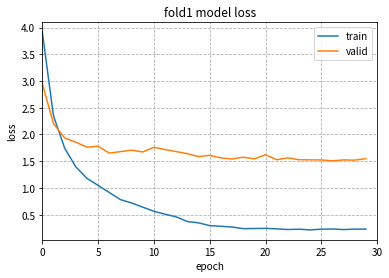

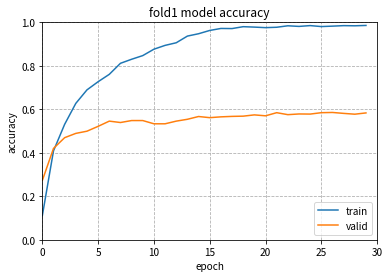

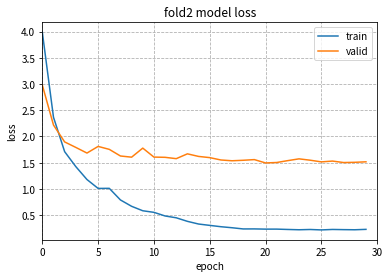

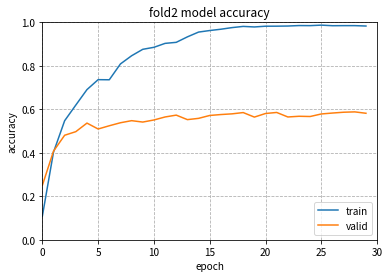

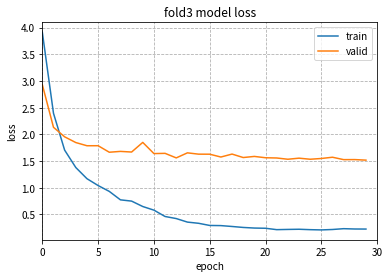

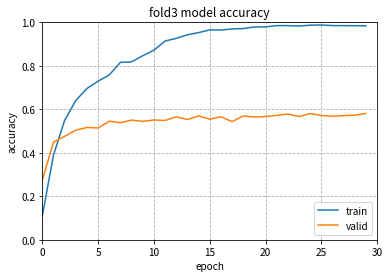

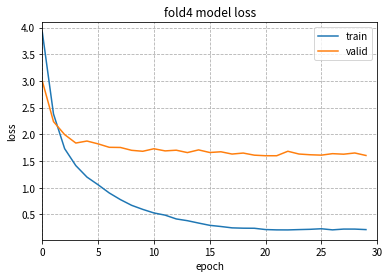

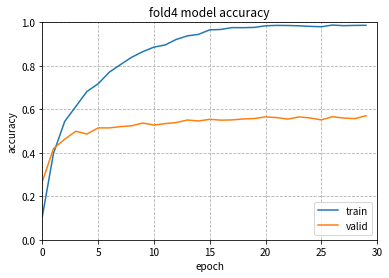

In [21]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
k = 0
l = 0
# [fold, :]
train_loss_his = []
train_acc_his = []
val_loss_his = []
val_acc_his = []
for i in range(kf.n_splits):
    # summarize history for loss
    plt.plot(train_loss_acc_list[l:l+num_epochs,0])
    plt.plot(val_loss_acc_list[l:l+num_epochs,0])
    plt.title('fold{} model loss'.format(i+1))
    plt.grid(linestyle='--')
    plt.xlim([0, num_epochs])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    plt.savefig(root_dir + 'fold_{}_loss_train_val.png'.format(i+1))
    plt.show()

    # summarize history for accuracy
    plt.plot(train_loss_acc_list[l:l+num_epochs,1])
    plt.plot(val_loss_acc_list[l:l+num_epochs,1])
    plt.title('fold{} model accuracy'.format(i+1))
    plt.grid(linestyle='--')
    plt.xlim([0, num_epochs])
    plt.ylim([0, 1])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='lower right')
    plt.savefig(root_dir + 'fold_{}_acc_train_val.png'.format(i+1))
    plt.show()

    l += num_epochs

    for j in range(num_epochs):
        writer.add_scalar('fold_{}_Loss/train'.format(i+1), train_loss_acc_list[k,0], j+1)
        writer.add_scalar('fold_{}_Loss/valid'.format(i+1), val_loss_acc_list[k,0], j+1)
        writer.add_scalar('fold_{}_Accuracy/train'.format(i+1), train_loss_acc_list[k,1], j+1)
        writer.add_scalar('fold_{}_Accuracy/valid'.format(i+1), val_loss_acc_list[k,1], j+1)

        k += 1

# graph
test = 'ほ？姫は当然、紅茶で優雅なティータイムなのですちょうど今から紅茶の時間なので、クッキーを……ね？'
encoded_str = torch.LongTensor(string_to_codepoint(test)).unsqueeze(0).to(device)
model = model.eval()
writer.add_graph(model, encoded_str)
writer.close()

In [0]:
!apt install graphviz
!pip install torchviz

In [0]:
from torchviz import make_dot

test = 'ほ？姫は当然、紅茶で優雅なティータイムなのですちょうど今から紅茶の時間なので、クッキーを……ね？'
encoded_str = torch.LongTensor(string_to_codepoint(test)).unsqueeze(0).to(device)
model = model.eval()
y = model(encoded_str)

dot= make_dot(y, params=dict(model.named_parameters()))
dot.render('model')

In [0]:
%load_ext tensorboard
%tensorboard --logdir ./runs

## evaluation

In [0]:
# 学習済みモデルを読み込む際はこのセルを実行
device = torch.device('cuda')
model = CLCNN(max_length=max_length, output_dim=14).to(device)
model.load_state_dict(torch.load('clcnn_best.pkl', map_location=device))
model.eval()

In [0]:
def codepoint_to_string(codepoints):
    decoded_str_list = []
    for _x in codepoints:
        if _x == 0:
            decoded_str_list += '－'
        if _x != 0:
            decoded_str_list += chr(_x)
    decoded_str = ''.join(decoded_str_list)

    return decoded_str

In [0]:
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, precision_recall_fscore_support

def result_report(model, test_loader):
    global idol_dict

    y_true = []
    y_pred = []
    results = []
    for y, z, x in test_loader:
        x = x.to(device) # encoded string

        with torch.no_grad():
            output = model(x)
            m = nn.Softmax(dim=1)
            result = m(output)
        y_p = int(result.cpu().argmax())
        y_t = int(y) # true label

        # (台詞テキスト, 予測ラベル, 正解ラベル，スコア)のタプルを追加
        results.append((codepoint_to_string(x.cpu().tolist()[0]), idol_dict[y_p], idol_dict[y_t], result.cpu().max().data.numpy()))
        y_pred.append(y_p)
        y_true.append(y_t)
        # batch_sizeごとにリストを結合
        #y_pred += [idol_dict[int(l.argmax())] for l in result]
        #y_true += [idol_dict[int(l)] for l in y]

    labels = [idol_dict[i] for i in range(len(idol_dict))]
    # classification report
    print(classification_report(y_true, y_pred, target_names=labels))
    class_repo = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    class_repo_df = pd.DataFrame(class_repo)
    # micro avg.
    micro_avg = precision_recall_fscore_support(y_true, y_pred, average="micro")
    micro_avg_df = pd.DataFrame({'precision': micro_avg[0], 'recall': micro_avg[1], 'f1-score': micro_avg[2]}, index=[0,])
    print(micro_avg_df)
    print('MCC(from -1 to 1):', matthews_corrcoef(y_true, y_pred))

    # tex用にテキストファイル出力
    with open(root_dir + 'classification_report.txt', 'w') as f:
        f.write(class_repo_df.round(2).T.to_latex())
    
    # confusion Matrix
    plt.figure(figsize=(20, 20))
    cmx_data = confusion_matrix(y_true, y_pred)
    cmx_df = pd.DataFrame(cmx_data, index=labels, columns=labels)
    sns.heatmap(cmx_df, square=True, annot=True, cmap='Blues')
    plt.savefig(root_dir + 'cmx.png')

    return results

              precision    recall  f1-score   support

      haruka       0.25      0.38      0.30        16
     chihaya       0.33      0.50      0.40        22
      yukiho       0.47      0.75      0.58        12
       karen       0.64      0.37      0.47        19
       emily       0.82      0.56      0.67        16
       shiho       0.32      0.41      0.36        17
      takane       0.78      0.47      0.58        15
      mizuki       0.83      0.50      0.62        20
     matsuri       0.89      0.85      0.87        20
         nao       0.67      0.78      0.72        18
      serika       0.75      0.57      0.65        21
        roco       0.75      0.86      0.80        14
      yuriko       0.14      0.43      0.21        14
      minako       0.17      0.19      0.18        16
       yayoi       0.58      0.39      0.47        18
      noriko       0.39      0.46      0.42        24
      megumi       0.57      0.91      0.70        22
        miya       0.47    

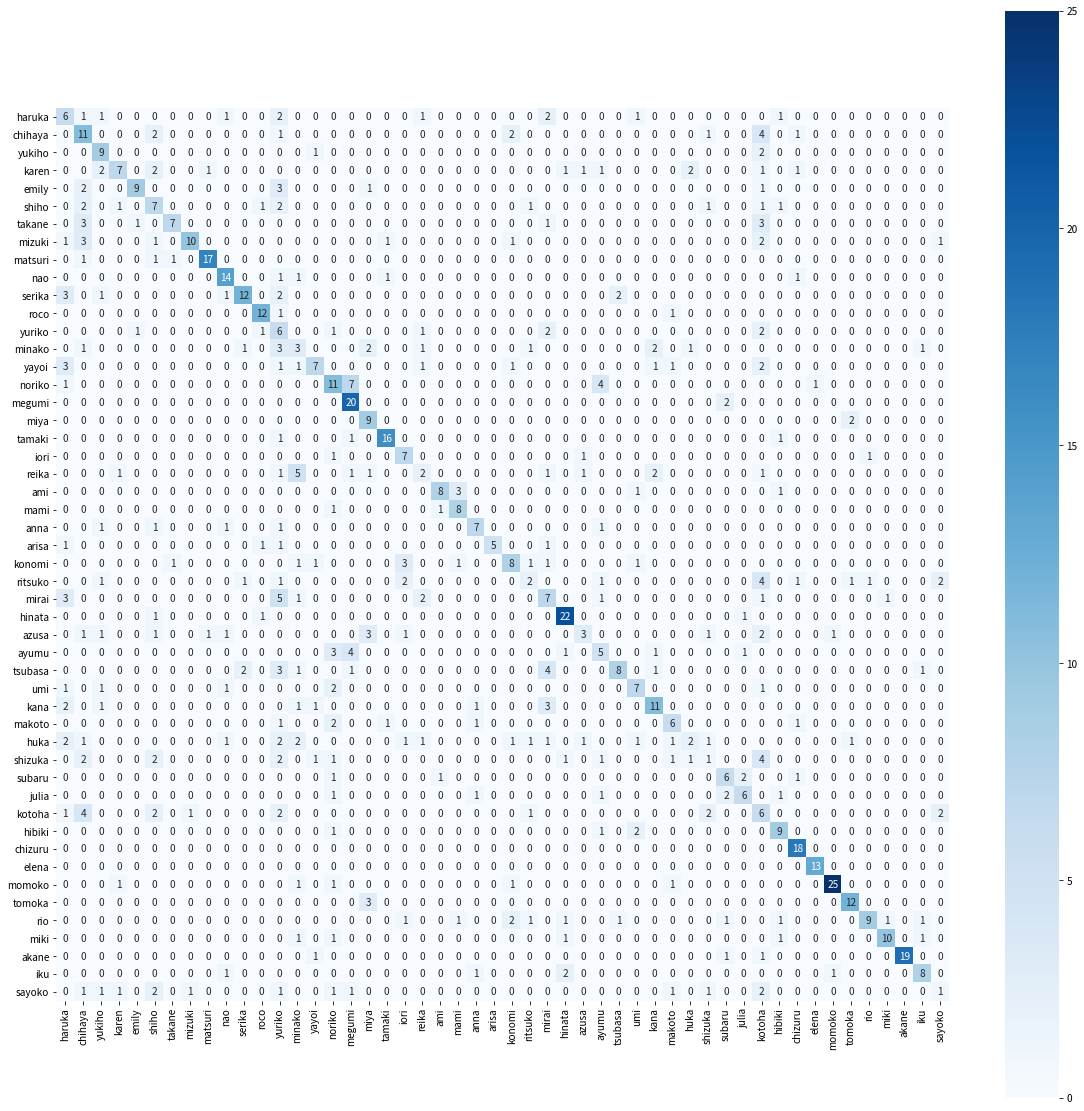

In [24]:
result_list = result_report(model, test_loader)

In [0]:
def export_result(eval_data):
    eval_np = np.array(eval_data)
    df = pd.DataFrame(eval_np, columns=['text', 'predicted', 'true', 'score'])
    df.to_csv(root_dir + 'evaluated_data.csv', index=False)
    return df

In [29]:
print(pd.get_option("display.max_rows"))
pd.set_option('display.max_rows', 10)
print(pd.get_option("display.max_rows"))

50
10


In [30]:
res_df = export_result(result_list)
res_df

,text,predicted,true,score
0,灯籠を流すと、姫の願いも海に届くような気がしますね、プロデューサーさん。…ほ？何を願う…です...,shiho,matsuri,0.64152646
1,今のリハーサル、手応えあった気がします！本番では、ああして、こうして…。ううっ、プロデューサ...,yuriko,mirai,0.629416
2,アタシのステージ、どう？プロデューサー！チョコみたいに甘く響いてる？あはは。だんだんノッてき...,noriko,noriko,0.5516869
3,遠く離れたこの異国でも、秋の情緒は変わりませんね。舞い散る紅葉の、なんと美しいことでしょう。...,chihaya,takane,0.47590527
4,きっと、困らせちゃうから…渡しちゃダメって思ってたんです。でも…この気持ち、抑えられない。…...,sayoko,kotoha,0.32415774
...,...,...,...,...
831,360度、あらゆる角度から撮るカメラ…ふふっ、面白いですね！どこから撮られてもいいよう、完璧...,ritsuko,shiho,0.40026322
832,えっ、こんなに大きな花束…いいんですか？…ありがとうございます、プロデューサー。真っ青で、と...,kotoha,chihaya,0.17619301
833,えへへ、やっぱライブって楽しいですね～♪今日はサイコーにドキドキさせてあげるから、絶対わたし...,tsubasa,tsubasa,0.97192985
834,プロデューサーさん、私も最近少しはアイドルオーラ出てきたと思いません？あ、何で笑うんですかっ...,mirai,yuriko,0.33738554


In [31]:
res_df.query('predicted == "kotoha"').sort_values('score', ascending=False)

,text,predicted,true,score
473,まつりちゃんと一緒だと、かわいいポーズも自然に取れますね。まつり姫の魔法で、私もお姫様になっ...,kotoha,kotoha,0.9577903
456,業界用語の一覧とか、ありませんか？私、ちゃんと覚えたいんです。－－－－－－－－－－－－－－－...,kotoha,kotoha,0.89158696
396,プロデューサーが聞いてくれるから、つい…色々と話し過ぎちゃいました。もしかして、そういう作戦...,kotoha,sayoko,0.786649
620,おはようございます、プロデユーサー。今日も自分に出来る限りのことは、していくつもりです！－－...,kotoha,sayoko,0.7861526
444,プロデューサー、顔色が悪いですよ…？早く、お薬を飲まないと…。この薬、私が処方したんです。と...,kotoha,kotoha,0.7631839
...,...,...,...,...
87,…できます！やらせてください。－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－...,kotoha,kotoha,0.24573188
286,寄り道していいですか？…うぐぐ、ダメですかぁ。－－－－－－－－－－－－－－－－－－－－－－－...,kotoha,reika,0.20466982
652,今時は携帯電話を使えば、現在地がわかっちゃうんです。あら？私、同じところをぐるぐる回って…？...,kotoha,azusa,0.19800045
641,今の私に必要なものは本棚です！アイドルのお仕事を始めてからまた本が増えてしまって…。－－－－...,kotoha,yuriko,0.18381883


# analysis

In [0]:
class GradCAM(nn.Module):
    def __init__(self, model, feature_layer):
        super(GradCAM, self).__init__()

        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層の逆伝播時の勾配を記録
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]]).to(device)
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

In [0]:
def n_gram(target, n):
    return [target[idx:idx + n] for idx in range(len(target) - n + 1)]

In [0]:
def gen_feature_heatmap(input_source, input_model=model):
    test_tensor = torch.LongTensor(string_to_codepoint(input_source)).unsqueeze(0).to(device)
    reversed_zero_padd_str = codepoint_to_string(test_tensor.tolist()[0])
    print(reversed_zero_padd_str)
    for i in range(len(input_model.convs1)):
        # Grad-CAMのインスタンス生成
        grad_cam = GradCAM(model=input_model, feature_layer=model.convs1[i])
        # モデルでの順伝播
        model_output = grad_cam.forward(test_tensor).to(device)
        predicted_label = torch.LongTensor([model_output.argmax().item()]).to(device)
        # 予測したラベルに対する逆伝播を計算
        grad_cam.backward_on_target(model_output, predicted_label)
        # 各特徴マップの要素に対する勾配を取得して平滑化
        feature_grad = grad_cam.feature_grad.cpu().data.numpy()[0]
        weights = np.mean(feature_grad, axis=(1, 2))
        # 重みを特徴マップに掛け合わせ後にReLUを適用
        feature_map = grad_cam.feature_map.cpu().data.numpy()
        cam = np.sum((weights * feature_map.T), axis=2).T
        cam = np.maximum(cam, 0)
        #print(pd.DataFrame(cam))
        # hookの初期化
        grad_cam.clear_hook()

        # iはfilter_sizeなので，filter_sizesから取得する方がいいけど，暫定で
        label_list = n_gram(reversed_zero_padd_str, i+2)
        print(label_list)
        cam_df = pd.DataFrame(cam, index=label_list)
        cam_df.to_csv(root_dir + 'gradcam_result_filter_size_{}.csv'.format(i+2))
        print(cam_df.sort_values(0, ascending=False))
        # ヒートマップの表示
        #print(pd.DataFrame(cam))
        plt.figure(figsize=(10, 20))
        plt.rcParams['font.family'] = 'Noto Sans CJK JP'
        sns.heatmap(cam_df, annot=True, fmt='.3f', robust=True)
        plt.savefig(root_dir + 'gradcam_result_filter_size_{}.png'.format(i+2))

In [41]:
predict('業界用語の一覧とか、ありませんか？私、ちゃんと覚えたいんです。')

predicted id: 39


,score
kotoha,8.915870e-01
yukiho,2.935408e-02
shiho,2.211218e-02
yuriko,1.890200e-02
chihaya,6.605390e-03
...,...
megumi,1.882704e-06
anna,1.501311e-06
ayumu,2.137216e-07
iku,1.885410e-07


業界用語の一覧とか、ありませんか？私、ちゃんと覚えたいんです。－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－
['業界', '界用', '用語', '語の', 'の一', '一覧', '覧と', 'とか', 'か、', '、あ', 'あり', 'りま', 'ませ', 'せん', 'んか', 'か？', '？私', '私、', '、ち', 'ちゃ', 'ゃん', 'んと', 'と覚', '覚え', 'えた', 'たい', 'いん', 'んで', 'です', 'す。', '。－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－', '－－']
           0
か、  0.007834
えた  0.006657
私、  0.005970
す。  0.004826
、あ  0.004747
..       ...
－－  0.000000
－－  0.000000
－－  0.000000
－－  0.000000
－－  0.000000

[89 rows x 1 columns]
['業界用', '界用語', '用語の', '語の一', 'の一覧', '一覧と', '覧とか', 'とか、', 'か、あ', '、あり', 'ありま', 'りませ', 'ません', 'せんか', 'んか？', 'か？私', '？私、', '私、ち', '、ちゃ', 'ちゃん', 'ゃんと', 'んと覚', 'と覚え', '覚えた', 'えたい', 'たいん', 'いんで', 'んです'

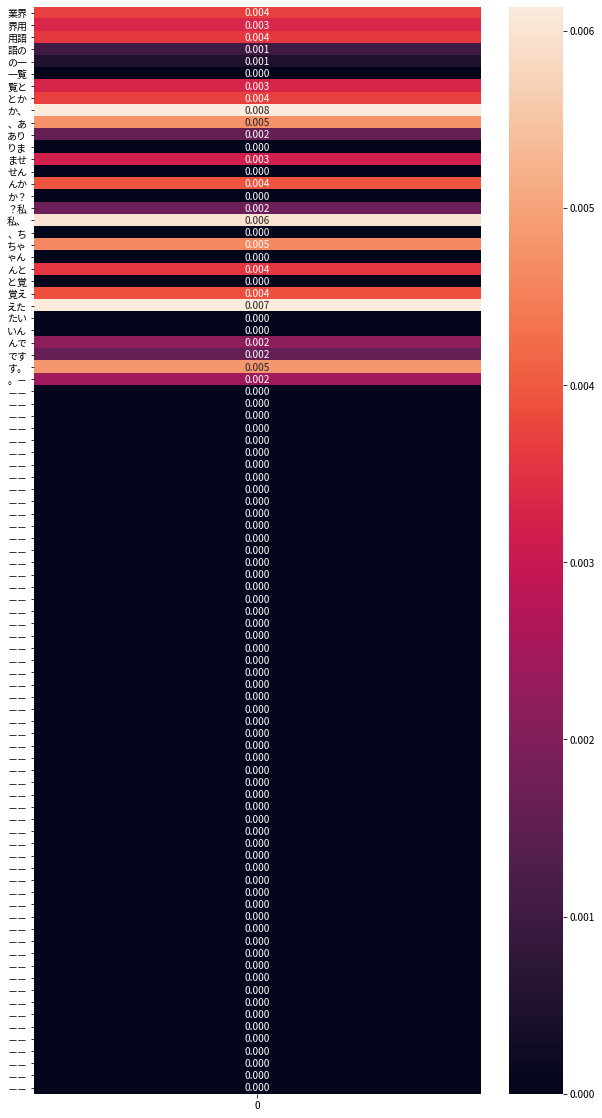

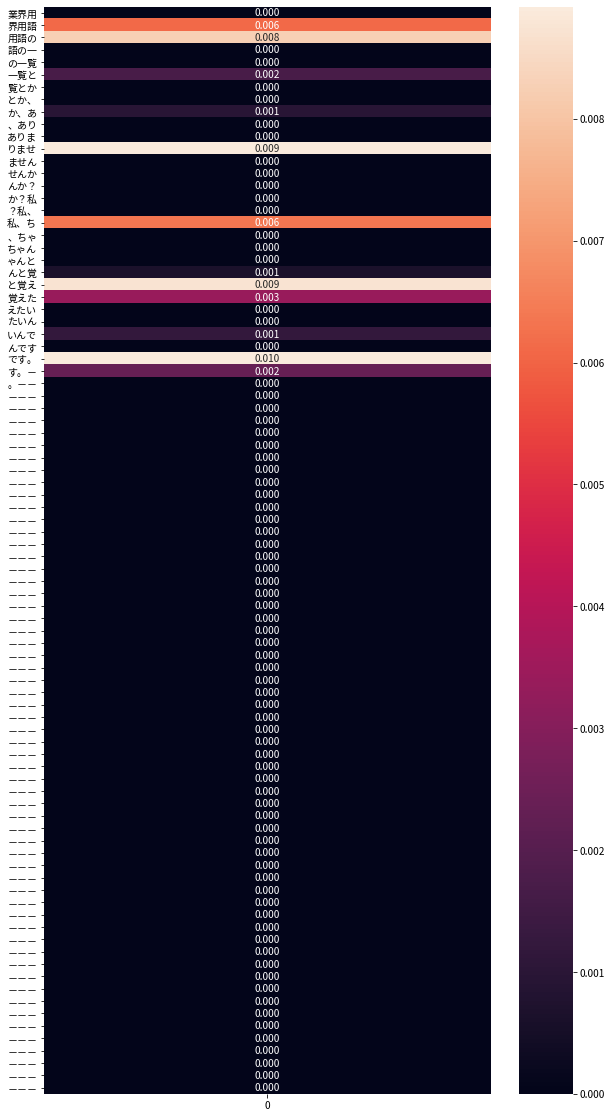

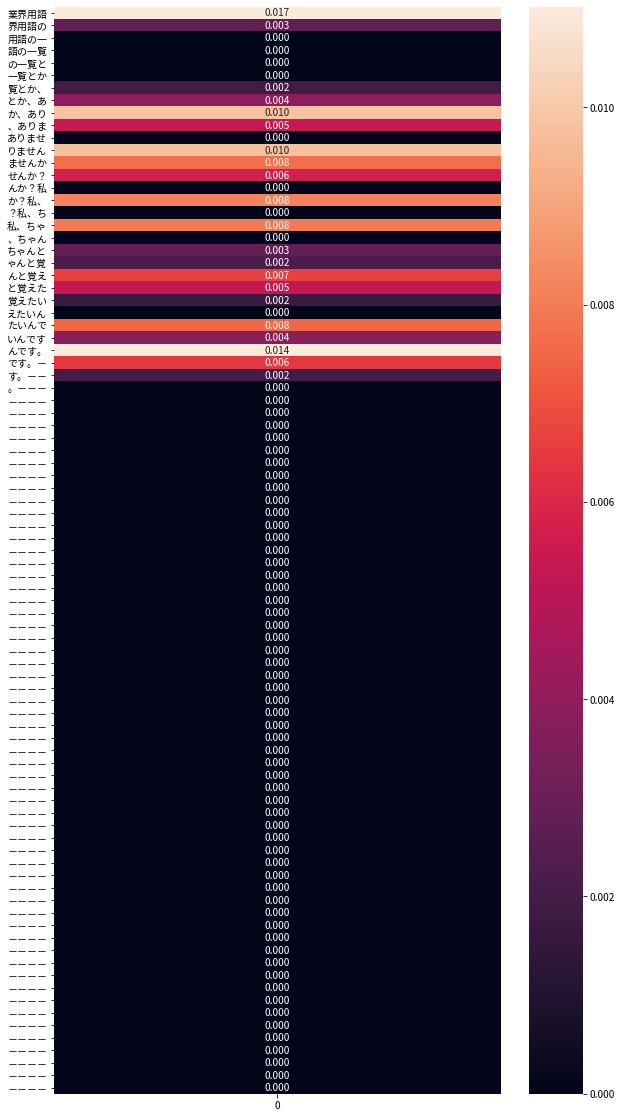

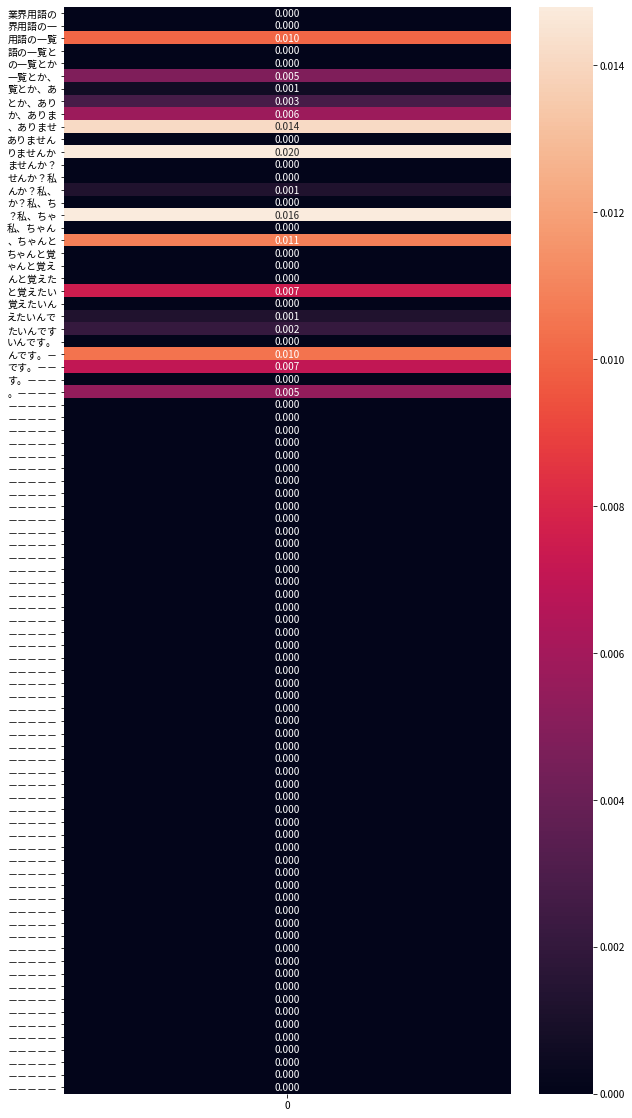

In [42]:
gen_feature_heatmap('業界用語の一覧とか、ありませんか？私、ちゃんと覚えたいんです。')